# **Data Cleaning and Sentiment Analysis of Facebook News Data**

This notebook performs data cleaning, preprocessing, and sentiment analysis on a dataset of Facebook news posts. The main steps include:  

1.	Importing necessary libraries.
2.	Defining helper functions for data cleaning and preprocessing.
3.	Importing and merging multiple CSV files containing the data.
4.	Cleaning and preprocessing the data.
5.	Calculating sentiment scores based on Facebook reactions.
6.	Saving the cleaned and processed data for further analysis.

## **1. Import Libraries**

First, we import the necessary libraries and download required NLTK data.

In [ ]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import nltk

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Import NLTK VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Import additional libraries
from transformers import BertTokenizer, BertModel
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## **2. Defining Helper Functions**

We define several helper functions for data cleaning and preprocessing

In [ ]:
# List of words/phrases to remove from titles
remove_words = [
    "opinion",
    "analysis",
    "perspective",
    "live updates",
    "review",
    "advice",
    "carolyn hax",
    "essay",
    "breaking news",
    "breaking",
    "fox news first",
    "column",
    "editorial",
    "commentary",
    "nbc news",
    "globe magazine",
    "trendlines",
    "on boston globe today",
    "wsj news exclusive",
    "exclusive",
    "cnn",
    "boston globe"
]

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def convert_to_int(value):
    """
    Converts a value to an integer, handling commas, 'K', 'M' suffixes, and removes unwanted text.

    Args:
        value: The value to convert.

    Returns:
        The converted value as an integer, or the original value if it cannot be converted.
    """
    try:
        # Convert to string, remove commas, convert to lowercase
        value = str(value).replace(',', '').lower()

        # Remove unwanted text
        for word in ['share', 'shares', 'comment', 'comments', 's']:
            value = value.replace(word, '')

        # Remove leading and trailing whitespace
        value = value.strip()

        # Handle 'K' and 'M' suffixes
        if value.endswith('k'):
            return int(float(value[:-1]) * 1000)
        elif value.endswith('m'):
            return int(float(value[:-1]) * 1000000)
        else:
            # Convert to float first, then to int
            return int(float(value))
    except ValueError:
        # If conversion fails, return the original value
        return value

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts.
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if no match

def preprocess_text(text):
    """
    Preprocesses the input text by lowercasing, removing special characters,
    tokenizing, removing stopwords, and lemmatizing.

    Args:
        text: The text to preprocess.

    Returns:
        The cleaned and preprocessed text.
    """
    # Lowercasing
    text = text.lower()

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and apply POS-specific lemmatization
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word not in stop_words]

    # Rejoin words to get the cleaned text
    return ' '.join(tokens)

def clean_specific_words(title):
    """
    Cleans the title by removing specified words or phrases.

    Args:
        title: The title to clean.

    Returns:
        The cleaned title.
    """
    pattern = r'\b(' + '|'.join(remove_words) + r')\b'
    cleaned_title = re.sub(pattern, '', title, flags=re.IGNORECASE)
    # Remove any extra whitespace that might result from removal
    cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
    return cleaned_title

def get_bert_embeddings(text):
    """
    Generates BERT embeddings for the given text.

    Args:
        text: The input text.

    Returns:
        A NumPy array containing the embeddings.
    """
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token's embeddings as the sentence representation
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embeddings

# Calculate sentiment score for the headlines
def calculate_sentiment_score(row):
    """
    Calculates the sentiment score for a row based on reaction ratios and predefined scores.

    Args:
        row: The DataFrame row.

    Returns:
        The sentiment score.
    """
    score = sum(row[reaction] * reaction_scores[reaction] for reaction in reaction_scores)
    return score

# Create sentiment classes based sentiment score for the headlines
def assign_sentiment_class(score):
    if score <= -0.1:
        return 0  # Strongly Negative
    elif -0.1 < score <= 0:
        return 1  # Negative
    elif 0 < score <= 0.1:
        return 2  # Positive
    else:
        return 3  # Strongly Positive

def calculate_news_label(row):
    """
    Assigns a news label based on the sentiment score.

    Args:
        row: The DataFrame row.

    Returns:
        1 if the sentiment score is positive, else 0.
    """
    if row['sentiment_score'] > 0:
        return 1
    else:
        return 0


# Define a function to get VADER sentiment scores
def get_vader_sentiment(text):
    """
    Returns the compound sentiment score for the given text using VADER.

    Args:
        text: The input text.

    Returns:
        The compound sentiment score.
    """
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']

# Create sentiment classes based on VADER sentiment score
def assign_vader_sentiment_class(score):
    if score <= -0.5:
        return 0  # Strongly Negative
    elif -0.5 < score < 0:
        return 1  # Negative
    elif 0 <= score <= 0.5:
        return 2  # Positive
    else:
        return 3  # Strongly Positive

## **3. Importing and Merging Data Files**

We import multiple CSV files containing the data and merge them into a single DataFrame.


In [ ]:
# Define the path to the directory containing CSV files
CSV_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/csv_files/'

# Get a list of all CSV files in the directory
file_list = [file for file in os.listdir(CSV_path) if os.path.isfile(os.path.join(CSV_path, file)) and file.endswith('.csv')]

# Initialize an empty list to hold the DataFrames
df_list = []

# Loop through the file list and read each CSV into a DataFrame
for file in file_list:
    file_path = os.path.join(CSV_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatenate all DataFrames into one DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined DataFrame to a CSV file
output_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined.csv'
combined_df.to_csv(output_path, index=False)

# Display the first few rows of the combined DataFrame
combined_df.head()

,news_org,title,summary,total_reactions,article_screenshot_s3_link,reactions_screenshot_s3_link,article_sc_date,reactions_sc_date,total_comments,total_shares,total_like,total_love,total_haha,total_wow,total_sad,total_angry,total_care,unrecognized_total,prompt_used_for_article_scrapping,prompt_used_for_reactions_scrapping
0,The_Wall_Street_Journal,Would You Zap Yourself With Electricity to Get...,One of the latest trends in boutique fitness i...,27,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:07:51,2024-10-14 16:07:55,4.0,3.0,25,0,1,0,0,1,0,NaN,Extract the following information from the giv...,Give me the count for each emoji reaction in J...
1,The_Wall_Street_Journal,Tesla Considers $775 Million Texas Factory Exp...,Tesla is considering more than $775 million in...,108,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:00,2024-10-14 16:08:05,15.0,3.0,88,4,12,2,0,1,1,NaN,Extract the following information from the giv...,Give me the count for each emoji reaction in J...
2,The_Wall_Street_Journal,Steven Spielberg’s ‘The Fabelmans’ Wins Best D...,"“The Fabelmans,” Steven Spielberg’s tale of a ...",184,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:24,2024-10-14 16:08:28,83.0,4.0,150,9,22,0,0,1,2,NaN,Extract the following information from the giv...,Give me the count for each emoji reaction in J...
3,The_Wall_Street_Journal,Abbott Elementary' Is a Golden Globes Favorite,Abbott Elementary' won three awards at the Gol...,273,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:33,2024-10-14 16:08:38,38.0,6.0,211,48,10,1,0,1,2,NaN,Extract the following information from the giv...,Give me the count for each emoji reaction in J...
4,The_Wall_Street_Journal,An Absent Cate Blanchett Wins Best Actress in ...,Cate Blanchett proved herself a movie maestro ...,263,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:45,2024-10-14 16:08:53,7.0,10.0,227,30,0,3,0,1,2,NaN,Extract the following information from the giv...,Give me the count for each emoji reaction in J...


In [ ]:
(combined_df['news_org']=='NBC_News').sum()

900

In [ ]:
# Load the merged DataFrame
CSV_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/'
combined_df = pd.read_csv(CSV_path + 'combined.csv')

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6644 entries, 0 to 6643
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   news_org                             6644 non-null   object 
 1   title                                6636 non-null   object 
 2   summary                              6635 non-null   object 
 3   total_reactions                      6639 non-null   object 
 4   article_screenshot_s3_link           6644 non-null   object 
 5   reactions_screenshot_s3_link         6644 non-null   object 
 6   article_sc_date                      6644 non-null   object 
 7   reactions_sc_date                    6644 non-null   object 
 8   total_comments                       6637 non-null   object 
 9   total_shares                         6597 non-null   object 
 10  total_like                           6644 non-null   int64  
 11  total_love                    

## **4. Data Cleaning and Preprocessing**

We clean the data by dropping unnecessary columns, handling missing values, and converting data types.

In [ ]:
# Drop unnecessary columns
combined_df = combined_df.drop(columns=[
    'unrecognized_total',
    'prompt_used_for_article_scrapping',
    'prompt_used_for_reactions_scrapping'
])

# Drop rows where 'title', 'summary', or 'total_reactions' are missing
combined_df = combined_df.dropna(subset=['title', 'summary', 'total_reactions'])

# Fill missing values in 'total_comments' and 'total_shares' with 0
combined_df['total_comments'] = combined_df['total_comments'].fillna(0)
combined_df['total_shares'] = combined_df['total_shares'].fillna(0)

In [ ]:
# Convert columns to integers
combined_df['total_reactions'] = combined_df['total_reactions'].apply(convert_to_int)
combined_df['total_comments'] = combined_df['total_comments'].apply(convert_to_int)
combined_df['total_shares'] = combined_df['total_shares'].apply(convert_to_int)
combined_df['total_like'] = combined_df['total_like'].apply(convert_to_int)
combined_df['total_love'] = combined_df['total_love'].apply(convert_to_int)
combined_df['total_haha'] = combined_df['total_haha'].apply(convert_to_int)
combined_df['total_wow'] = combined_df['total_wow'].apply(convert_to_int)
combined_df['total_sad'] = combined_df['total_sad'].apply(convert_to_int)
combined_df['total_angry'] = combined_df['total_angry'].apply(convert_to_int)
combined_df['total_care'] = combined_df['total_care'].apply(convert_to_int)

In [ ]:
# Calculate the ratios of each reaction type
combined_df['ratio_love'] = combined_df['total_love'] / combined_df['total_reactions']
combined_df['ratio_haha'] = combined_df['total_haha'] / combined_df['total_reactions']
combined_df['ratio_wow'] = combined_df['total_wow'] / combined_df['total_reactions']
combined_df['ratio_sad'] = combined_df['total_sad'] / combined_df['total_reactions']
combined_df['ratio_angry'] = combined_df['total_angry'] / combined_df['total_reactions']
combined_df['ratio_care'] = combined_df['total_care'] / combined_df['total_reactions']

## **5. Text Preprocessing**

We preprocess the ‘title’ and ‘summary’ columns by cleaning and lemmatizing the text.

In [ ]:
# Apply preprocessing to each title and summary
combined_df['cleaned_title'] = combined_df['title'].apply(preprocess_text)
combined_df['cleaned_title'] = combined_df['cleaned_title'].apply(clean_specific_words)

combined_df['cleaned_summary'] = combined_df['summary'].apply(preprocess_text)
combined_df['cleaned_summary'] = combined_df['cleaned_summary'].apply(clean_specific_words)


## **6. Feature Extraction**

In this step, we use the BERT model to extract embeddings from the preprocessed titles and summaries. These embeddings capture the semantic meaning of the text and are useful for various downstream tasks like clustering or classification.



### **6.1 Load BERT Model and Tokenizer**

In [ ]:
# # Load BERT tokenizer and model
# from transformers import BertTokenizer, BertModel

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)
# model = BertModel.from_pretrained('bert-base-uncased')

### **6.2 Generate Embeddings for Titles and Summaries**

In [ ]:
# # Get embeddings for each preprocessed title
# embeddings_title = np.array([get_bert_embeddings(title) for title in combined_df['cleaned_title']])

# # Get embeddings for each preprocessed summary
# embeddings_summary = np.array([get_bert_embeddings(summary) for summary in combined_df['cleaned_summary']])

### **6.3 Concatenate Title and Summary Embeddings**

We concatenate the embeddings from titles and summaries to create a comprehensive feature set for each news post.

In [ ]:
# # Concatenate embeddings
# embeddings = np.concatenate((embeddings_title, embeddings_summary), axis=1)

### **6.4 Save Embeddings for Future Use**

In [ ]:
# Define the output path for saving embeddings
emb_output_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/Project_Notebooks/'

In [ ]:
# # Save embeddings as .npz files
# np.savez(emb_output_path + 'bert_embeddings_title_new.npz', embeddings=embeddings_title)
# np.savez(emb_output_path + 'bert_embeddings_summary_new.npz', embeddings=embeddings_summary)
# np.savez(emb_output_path + 'bert_embeddings_concatenated_new.npz', embeddings=embeddings)

### **6.5 Load Embeddings (If Needed)**

In [ ]:
# To load the embeddings again
loaded_data = np.load(emb_output_path + 'bert_embeddings_title.npz')
embeddings_title = loaded_data['embeddings']

loaded_data = np.load(emb_output_path + 'bert_embeddings_summary.npz')
embeddings_summary = loaded_data['embeddings']

loaded_data = np.load(emb_output_path + 'bert_embeddings_concatenated.npz')
embeddings = loaded_data['embeddings']

## **7. Sentiment Analysis of News Headlines and Facebook Reactions Using VADER**

In this section, we utilize the VADER sentiment analyzer to calculate the initial sentiment polarity of news headlines and subsequently derive sentiment scores for Facebook reactions. This process allows us to establish a connection between the inherent sentiment of the news headlines and the emotional responses they evoke on social media.




### **7.1 Calculate Sentiment Scores for Headlines using NLTK VADER**

We initialize the VADER sentiment analyzer to compute sentiment scores for the cleaned headlines.

In [ ]:
# Initialize the VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

### **7.2 Calculate Sentiment Scores for Headlines**

Using VADER, we compute the sentiment score for each cleaned headline and store it in a new column vader_sentiment_score.

In [ ]:
# Apply the function to the cleaned titles
combined_df['vader_sentiment_score'] = combined_df['cleaned_title'].apply(get_vader_sentiment)

### **7.3 7.3 Handle Neutral Sentiments Using Cosine Similarity**

To handle cases where vader_sentiment_score equals 0, we use the cosine similarity between embeddings. For each neutral embedding:
1.	Calculate its cosine similarity with all non-neutral embeddings.
2.	Assign the sentiment score of the most similar embedding.



In [ ]:
# Add embeddings to the DataFrame for easy filtering
combined_df['embedding'] = list(embeddings_title)

# Step 1: Split embeddings into neutral and non-neutral groups
neutral_embeddings = combined_df[combined_df['vader_sentiment_score'] == 0][['embedding', 'vader_sentiment_score']]
non_neutral_embeddings = combined_df[combined_df['vader_sentiment_score'] != 0][['embedding', 'vader_sentiment_score']]

# Convert embeddings into NumPy arrays
neutral_embeddings_array = np.array(list(neutral_embeddings['embedding']))
non_neutral_embeddings_array = np.array(list(non_neutral_embeddings['embedding']))

# Extract corresponding vader_sentiment_scores for non-neutral embeddings
non_neutral_scores = non_neutral_embeddings['vader_sentiment_score'].values

# Step 2: Calculate cosine similarity between each neutral embedding and all non-neutral embeddings
# Initialize a list to store the assigned scores
assigned_scores = []

for neutral_embedding in neutral_embeddings_array:
    # Calculate cosine similarity with all non-neutral embeddings
    similarities = cosine_similarity([neutral_embedding], non_neutral_embeddings_array)[0]

    # Find the index of the most similar non-neutral embedding
    most_similar_index = np.argmax(similarities)

    # Assign the sentiment score of the most similar non-neutral embedding
    assigned_scores.append(non_neutral_scores[most_similar_index])

# Step 3: Update the DataFrame with assigned scores
combined_df.loc[combined_df['vader_sentiment_score'] == 0, 'vader_sentiment_score'] = assigned_scores

### **7.4 Assign VADER Sentiment Classes**

Using the vader_sentiment_score, we classify the headlines into four sentiment classes:
- 0: Strongly Negative
-	1: Negative
-	2: Positive
-	3: Strongly Positive

In [ ]:
combined_df['vader_sentiment_class'] = combined_df['vader_sentiment_score'].apply(assign_vader_sentiment_class)

### **7.5 Examine the Distribution of VADER Sentiment Scores and Classes**

#### *7.5.1 Histogram of Sentiment Scores*

We visualize the distribution of vader_sentiment_score to understand the overall sentiment spread.

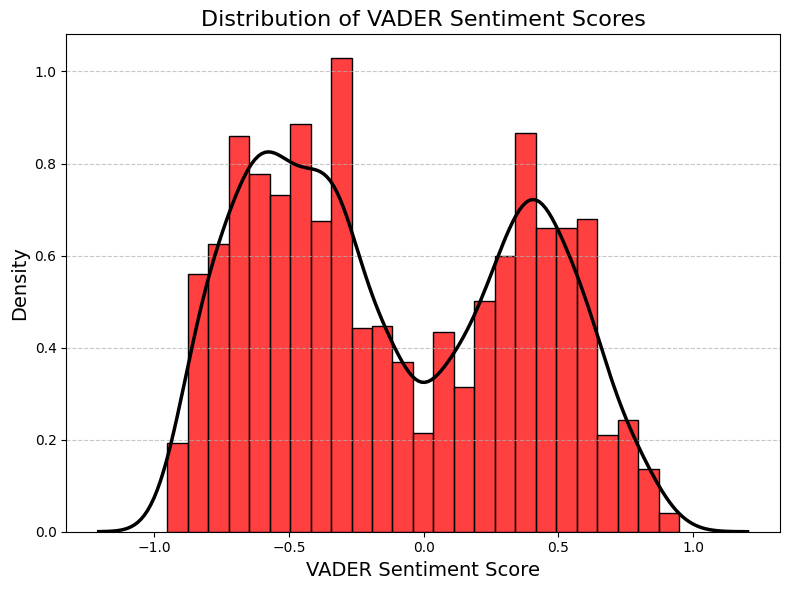

In [ ]:
# Create the histogram and KDE plot
plt.figure(figsize=(8, 6))
sns.histplot(combined_df['vader_sentiment_score'], bins=25, color='red', edgecolor='black', stat='density')
sns.kdeplot(combined_df['vader_sentiment_score'], color='black', linewidth=2.5)

# Add labels and title
plt.title('Distribution of VADER Sentiment Scores', fontsize=16)
plt.xlabel('VADER Sentiment Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

#### *7.5.2 Histogram of Sentiment Classes*

We plot the distribution of sentiment classes to observe their proportions.

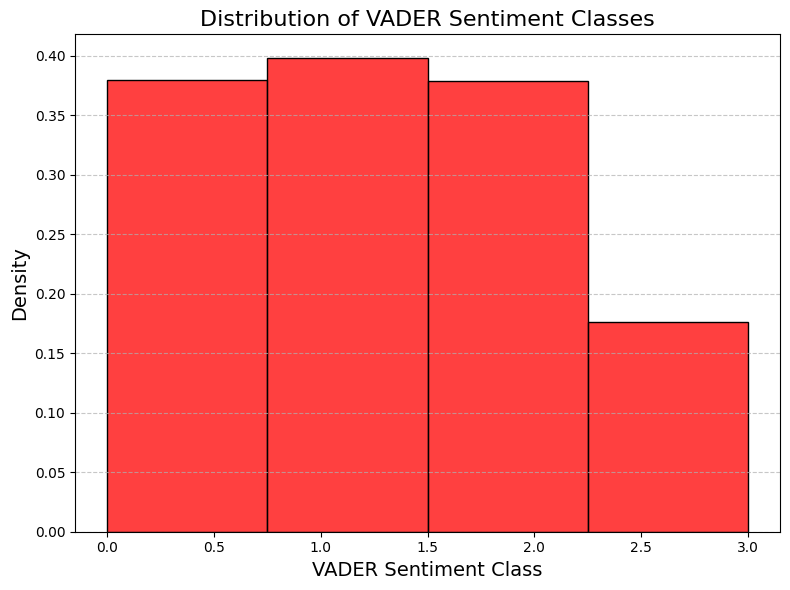

In [ ]:
# Create a histogram for sentiment classes
plt.figure(figsize=(8, 6))
sns.histplot(combined_df['vader_sentiment_class'], bins=4, color='red', edgecolor='black', stat='density')

# Add labels and title
plt.title('Distribution of VADER Sentiment Classes', fontsize=16)
plt.xlabel('VADER Sentiment Class', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **7.6 Weighted Sentiment Scores for Reactions**

We calculate weighted sentiment scores for each reaction type based on the VADER sentiment classes.



In [ ]:
# Define reactions excluding total_like
reaction_columns = ['total_love', 'total_haha', 'total_wow', 'total_sad', 'total_angry', 'total_care']

# Group by VADER sentiment class and calculate the sum of reactions
reaction_totals = combined_df.groupby('vader_sentiment_class')[reaction_columns].sum()

# Define weights for each position in sorted values
negative_weights = np.array([-1, -0.81818182, -0.63636364, -0.45454545, -0.27272727, -0.09090909])
positive_weights = np.array([1, 0.81818182, 0.63636364, 0.45454545, 0.27272727, 0.09090909])

# Initialize an empty DataFrame to store the weighted reactions (4x6 matrix)
weighted_reactions_df = pd.DataFrame(index=reaction_totals.index, columns=reaction_columns)

# Iterate through each sentiment class
for sentiment_class in reaction_totals.index:
    # Sort the reactions for this class in descending order
    sorted_reactions = reaction_totals.loc[sentiment_class].sort_values(ascending=False)

    # Select weights based on sentiment class
    if sentiment_class in [0, 1]:  # Negative classes
        weights = negative_weights
    else:  # Positive classes
        weights = positive_weights

    # Multiply the sorted reactions by the weights
    weighted_values = sorted_reactions.values * weights

    # Map the weighted values back to the original reaction columns
    weighted_reactions_df.loc[sentiment_class, sorted_reactions.index] = weighted_values

# Convert weighted_reactions_df to numeric (optional for calculations)
weighted_reactions_df = weighted_reactions_df.astype(float)


### **7.7 Calculate Sentiment Scores for Each Reaction**

We normalize the weighted values by dividing by the total reaction counts to obtain sentiment scores for each reaction.

In [ ]:
# Sum up the weighted values for each reaction across all classes
reaction_sentiment_scores = weighted_reactions_df.sum(axis=0)

# Divide by the total number of reactions for normalization
total_reactions = reaction_totals.sum(axis=0)
reaction_sentiment_scores_normalized = reaction_sentiment_scores / total_reactions

# Display the sentiment scores for each reaction
print("Sentiment Scores for Each Reaction:")
print(reaction_sentiment_scores_normalized)

Sentiment Scores for Each Reaction:
total_love     0.560398
total_haha    -0.121458
total_wow     -0.034580
total_sad     -0.619425
total_angry   -0.198360
total_care     0.074180
dtype: float64


### **7.8 Calculate Sentiment Scores and Sentiment Classes for the Headlines**






In [ ]:
# Define sentiment scores for each reaction
reaction_scores = {
    'ratio_love': reaction_sentiment_scores_normalized['total_love'],
    'ratio_haha': reaction_sentiment_scores_normalized['total_haha'],
    'ratio_wow': reaction_sentiment_scores_normalized['total_wow'],
    'ratio_sad': reaction_sentiment_scores_normalized['total_sad'],
    'ratio_angry': reaction_sentiment_scores_normalized['total_angry'],
    'ratio_care': reaction_sentiment_scores_normalized['total_care']
}


combined_df['sentiment_score'] = combined_df.apply(calculate_sentiment_score, axis=1)

In [59]:
reaction_scores

{'ratio_love': 0.5603976424256577,
 'ratio_haha': -0.12145808796907585,
 'ratio_wow': -0.0345798738425862,
 'ratio_sad': -0.6194250849263545,
 'ratio_angry': -0.1983600959346672,
 'ratio_care': 0.07418011056384123}

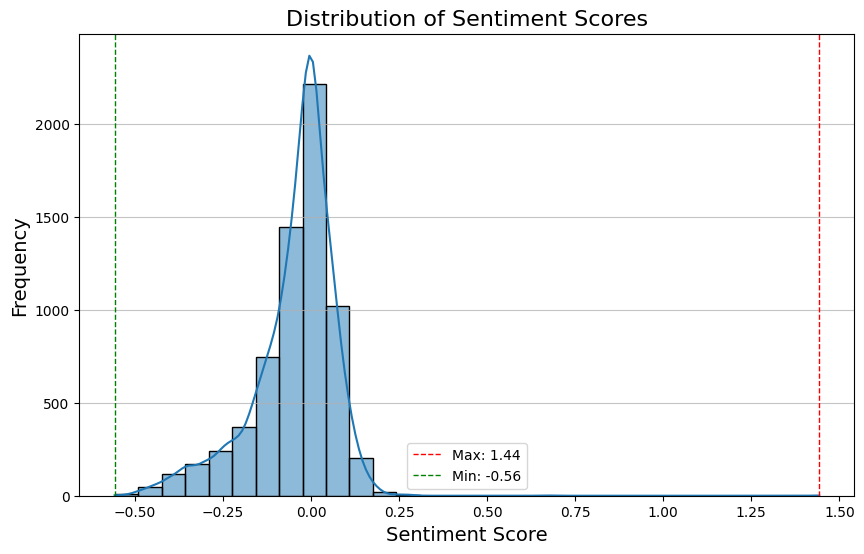

In [ ]:
# prompt: histogram of combined_df['sentiment_score']  and max and min values

import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram and KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['sentiment_score'], bins=30, kde=True)  # Increased bins for better visualization

# Add labels and title
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display max and min values
max_sentiment = combined_df['sentiment_score'].max()
min_sentiment = combined_df['sentiment_score'].min()
plt.axvline(max_sentiment, color='r', linestyle='dashed', linewidth=1, label=f'Max: {max_sentiment:.2f}')
plt.axvline(min_sentiment, color='g', linestyle='dashed', linewidth=1, label=f'Min: {min_sentiment:.2f}')

plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
combined_df['headline_sentiment_class'] = combined_df['sentiment_score'].apply(assign_sentiment_class)


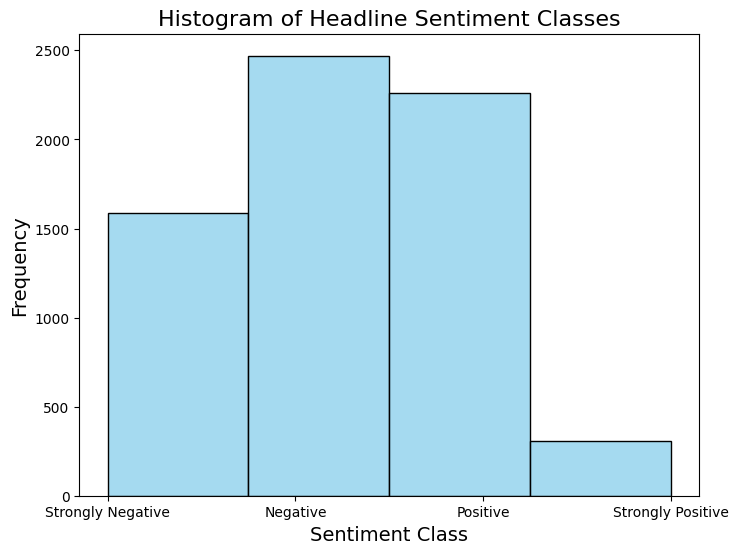

In [ ]:
# prompt: histogram of combined_df['headline_sentiment_class']

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is already loaded as in your provided code

plt.figure(figsize=(8, 6))
sns.histplot(combined_df['headline_sentiment_class'], bins=4, color='skyblue', edgecolor='black')
plt.title('Histogram of Headline Sentiment Classes', fontsize=16)
plt.xlabel('Sentiment Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks([0, 1, 2, 3], ['Strongly Negative', 'Negative', 'Positive', 'Strongly Positive'])
plt.show()

In [ ]:
combined_df.head()

,news_org,title,summary,total_reactions,article_screenshot_s3_link,reactions_screenshot_s3_link,article_sc_date,reactions_sc_date,total_comments,total_shares,...,ratio_sad,ratio_angry,ratio_care,cleaned_title,cleaned_summary,vader_sentiment_score,embedding,vader_sentiment_class,sentiment_score,headline_sentiment_class
0,The_Wall_Street_Journal,Would You Zap Yourself With Electricity to Get...,One of the latest trends in boutique fitness i...,27,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:07:51,2024-10-14 16:07:55,4,3,...,0.0,0.037037,0.000000,would zap electricity get shape,one late trend boutique fitness electrify lite...,-0.1027,"[-0.09651708, -0.066740185, 0.22686258, 0.2463...",1,-0.011845,1
1,The_Wall_Street_Journal,Tesla Considers $775 Million Texas Factory Exp...,Tesla is considering more than $775 million in...,108,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:00,2024-10-14 16:08:05,15,3,...,0.0,0.009259,0.009259,tesla considers million texas factory expansion,tesla consider million expansion electricvehic...,-0.4215,"[-0.3150386, 0.083913706, 0.26323605, -0.04117...",1,0.005470,1
2,The_Wall_Street_Journal,Steven Spielberg’s ‘The Fabelmans’ Wins Best D...,"“The Fabelmans,” Steven Spielberg’s tale of a ...",184,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:24,2024-10-14 16:08:28,83,4,...,0.0,0.005435,0.010870,steven spielberg fabelmans win best drama,fabelmans steven spielberg tale childhood indo...,0.8402,"[-0.57255256, 0.19042005, 0.298331, -0.2424583...",3,0.012617,3
3,The_Wall_Street_Journal,Abbott Elementary' Is a Golden Globes Favorite,Abbott Elementary' won three awards at the Gol...,273,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:33,2024-10-14 16:08:38,38,6,...,0.0,0.003663,0.007326,abbott elementary golden globe favorite,abbott elementary three award golden globe inc...,0.4588,"[-0.6081027, -0.10318553, 0.18764025, -0.13013...",2,0.093773,2
4,The_Wall_Street_Journal,An Absent Cate Blanchett Wins Best Actress in ...,Cate Blanchett proved herself a movie maestro ...,263,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:45,2024-10-14 16:08:53,7,10,...,0.0,0.003802,0.007605,absent cate blanchett win best actress motion ...,cate blanchett prove movie maestro tr earn bes...,0.8402,"[-0.7721644, 0.14760873, -0.22090933, -0.06182...",3,0.063339,3


### **7.9 Calculate News Labels**

Finally, we calculate new labels (news_label) based on the updated sentiment scores.

In [ ]:
# Assign new news labels based on sentiment score
combined_df['news_label'] = combined_df.apply(calculate_news_label, axis=1)

## **9. Saving the Cleaned and Processed Data**

Finally, we save the cleaned and processed DataFrame to a CSV file for future use.

In [ ]:
# output_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined_COMPLETE.csv'
# combined_df.to_csv(output_path, index=False)


To use the data in our model, however, we need to exclude the news articles added from the file across_news_orgs.csv. These articles are reserved for a secondary branch of the main project, meaning they must remain entirely unseen by the models we will implement. This ensures that the models are not influenced by this subset of news articles.

In [ ]:
# # Delete rows from index 6644 onward
# combined_df = combined_df.iloc[:6644]

# # Verify the updated DataFrame
# print(combined_df.info())

In [ ]:
# combined_df.tail()

In [ ]:
output_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined_FINAL.csv'
combined_df.to_csv(output_path, index=False)